In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

Our metric of an actor's success can be based on two factors: 
 - awards (in particular, Oscar) show an actor's recognition by the professional community
 - popularity shows an actor's recognition by the broad audience

We can aggregate these factors as follows:

$ Success(P, N, W, t) = P\_scale(t) * P + N\_scale * N + W\_scale * W $

In the formula P corresponds to popularity (from TMDB or new database with the most popular actors), N corresponds to the number of Oscar nominations of an actor and W is the number of times the actor became an Oscar winner. Scaling factors are constants for an award-related part, but $P\_scale(t)$ is a decreasing function of time period - how far was a peak of an actor's career from now. The motivation is that the popularity of actors who starred recently is supposed to be higher than the popularity of their retired colleagues.

In [3]:
# database with Oscar statistics retrieved from https://en.wikipedia.org/wiki/List_of_actors_with_Academy_Award_nominations
oscars_df = pd.read_csv('../Data/preprocessed_data/oscars_db.csv')

In [4]:
oscars_df = oscars_df[["name", "nominations", "wins"]]
display(oscars_df)
print(f"There are {oscars_df.shape[0]} actors with Oscar nominations/wins in the dataset")

,name,nominations,wins
0,Barkhad Abdi,1,0
1,F. Murray Abraham,1,1
2,Amy Adams,6,0
3,Nick Adams,1,0
4,Isabelle Adjani,2,0
...,...,...,...
965,Loretta Young,2,1
966,Roland Young,1,0
967,Youn Yuh-jung,1,1
968,Renée Zellweger,4,2


There are 970 actors with Oscar nominations/wins in the dataset


Popularity of the actors and films they are known for were extracted in Preprocessing/actors_preprocessing.ipynb. In our analysis we are targeting Hollywood actors, since the Oscar is Hollywood-biased. For this, we apply filtering based on the prevalent language of the most popular films ("original_language" field in the database) of each actor and leave only English ones. 

*This filtering does not reject British film industry but their movies and actors are also eligible for Oscar.

In [5]:
actors_df = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
actors_df = actors_df[actors_df["original_language"] == "en"] # English movies filtering
popularity_df = actors_df[["name", "popularity", "known_for"]] # for each actor known_for contains top-3 most recognised movies
display(popularity_df)
print(f"There are {popularity_df.shape[0]} actors in the filtered dataset")

,name,popularity,known_for
1,Gary Oldman,220.449,"[{'adult': False, 'backdrop_path': '/nMKdUUepR..."
3,Florence Pugh,176.589,"[{'adult': False, 'backdrop_path': '/aAM3cQmYG..."
4,Jason Statham,162.466,"[{'adult': False, 'backdrop_path': '/ysKahAEPP..."
6,Jackie Chan,156.714,"[{'adult': False, 'backdrop_path': '/r4yFYBEcV..."
7,Scarlett Johansson,156.460,"[{'adult': False, 'backdrop_path': '/ozVwXlfxq..."
...,...,...,...
9574,Richard Derr,14.134,"[{'adult': False, 'backdrop_path': '/ws8eX1paK..."
9575,Michael Maloney,14.134,"[{'adult': False, 'backdrop_path': '/9YoLdWeBS..."
9576,Gaia Scodellaro,14.133,"[{'adult': False, 'backdrop_path': '/tC78Pck2Y..."
9578,Peter Cullen,14.133,"[{'adult': False, 'backdrop_path': '/2vFuG6bWG..."


There are 8441 actors in the filtered dataset


We need to extract additionally the date of release of the newest popular movie to make time scaling

In [54]:
def get_last_release_date(movie_column):
    actor_movies = movie_column.values
    print(len(actor_movies))
    last_release_dates = sorted(actor_movies, key=lambda x: x['release_date'], reverse=True)
    return last_release_dates

popularity_df = popularity_df.assign(last_release_date = get_last_release_date(popularity_df["known_for"]))
popularity_df.head()

8441


TypeError: string indices must be integers

In [6]:
actors_df = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
actors_df = actors_df[actors_df["original_language"] == "en"]
popularity_df = actors_df[["name", "popularity"]]

In [7]:
# merging 2 databases to get popularity, nominations and awards in a single database
success_df = pd.merge(left=popularity_df, right=oscars_df, how="left", on=["name"])
success_df = success_df.fillna(0)
display(success_df)

,name,popularity,nominations,wins
0,Gary Oldman,220.449,3.0,1.0
1,Florence Pugh,176.589,1.0,0.0
2,Jason Statham,162.466,0.0,0.0
3,Jackie Chan,156.714,0.0,0.0
4,Scarlett Johansson,156.460,2.0,0.0
...,...,...,...,...
8436,Richard Derr,14.134,0.0,0.0
8437,Michael Maloney,14.134,0.0,0.0
8438,Gaia Scodellaro,14.133,0.0,0.0
8439,Peter Cullen,14.133,0.0,0.0


In [39]:
# merging 2 databases to get popularity, nominations and awards in a single database
success_df = pd.merge(left=popularity_df, right=oscars_df, how="left", on=["name"])
success_df = success_df.fillna(0)
display(success_df)

,name,popularity,nominations,wins
0,Gary Oldman,220.449,3.0,1.0
1,Florence Pugh,176.589,1.0,0.0
2,Jason Statham,162.466,0.0,0.0
3,Jackie Chan,156.714,0.0,0.0
4,Scarlett Johansson,156.460,2.0,0.0
...,...,...,...,...
8436,Richard Derr,14.134,0.0,0.0
8437,Michael Maloney,14.134,0.0,0.0
8438,Gaia Scodellaro,14.133,0.0,0.0
8439,Peter Cullen,14.133,0.0,0.0


In [8]:
# for now we consider P_scale(t) constant, will change later
P_SCALE = 1.0
N_SCALE = 5.0
W_SCALE = 10.0

success_df = success_df.assign(metric = lambda x: P_SCALE * success_df["popularity"] + \
                               N_SCALE * success_df["nominations"] + W_SCALE * success_df["wins"])
success_df.head()

,name,popularity,nominations,wins,metric
0,Gary Oldman,220.449,3.0,1.0,245.449
1,Florence Pugh,176.589,1.0,0.0,181.589
2,Jason Statham,162.466,0.0,0.0,162.466
3,Jackie Chan,156.714,0.0,0.0,156.714
4,Scarlett Johansson,156.460,2.0,0.0,166.460


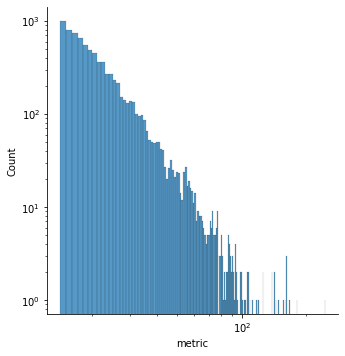

In [9]:
sns.displot(success_df["metric"])
plt.xscale('log')
plt.yscale('log')

According to our metric, here are the top actors

In [10]:
success_df = success_df.sort_values(by="metric", ascending=False)
success_df.head(10)

,name,popularity,nominations,wins,metric
0,Gary Oldman,220.449,3.0,1.0,245.449
1,Florence Pugh,176.589,1.0,0.0,181.589
4,Scarlett Johansson,156.460,2.0,0.0,166.460
2,Jason Statham,162.466,0.0,0.0,162.466
7,Nicolas Cage,141.980,2.0,1.0,161.980
1855,Meryl Streep,26.710,21.0,3.0,161.710
6,Brie Larson,146.066,1.0,1.0,161.066
3,Jackie Chan,156.714,0.0,0.0,156.714
5,Josh Hutcherson,148.736,0.0,0.0,148.736
9,Michael Fassbender,134.613,2.0,0.0,144.613
